In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from stable_baselines3 import SAC, PPO, A2C

import os
import sys
import time
import subprocess
from PIL import Image
import numpy as np
import torch
import yaml
from torchvision import transforms
from experiment import VAEXperiment
from models import *

import gymnasium as gym
from gymnasium import ObservationWrapper
from gymnasium.wrappers import PixelObservationWrapper, FrameStack
from gymnasium.spaces import Box, Discrete

from stable_baselines3 import SAC, PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [58]:
from tbparse import SummaryReader
log_dir = "RLmodels/MountainCarContinuous-v0/Double_loop/logs/BCE_VAE_l3_test2_PPO_v1__0vae_resets__0rl_resets___0"
reader = SummaryReader(log_dir)
df = reader.scalars
print(df)

      step                  tag       value
0     1008  rollout/ep_len_mean  999.000000
1     1016  rollout/ep_len_mean  999.000000
2     1024  rollout/ep_len_mean  999.000000
3     1032  rollout/ep_len_mean  999.000000
4     1040  rollout/ep_len_mean  999.000000
...    ...                  ...         ...
3248  2976     train/value_loss    0.000313
3249  2984     train/value_loss    0.000090
3250  2992     train/value_loss    0.000022
3251  3000     train/value_loss    0.000013
3252  3008     train/value_loss    0.000011

[3253 rows x 3 columns]


In [55]:
tags = pd.DataFrame()
tags = df.groupby(['tag'])

In [59]:
for key, group in tags:
    print(key)
    if key == ('rollout/ep_len_mean',):
        ep_len = group
        print(ep_len)
    if key == ('rollout/ep_rew_mean',):
        ep_rew = group
        print(ep_rew)

('rollout/ep_len_mean',)
     step                  tag  value
0    3016  rollout/ep_len_mean  999.0
1    3024  rollout/ep_len_mean  999.0
2    3032  rollout/ep_len_mean  999.0
3    3040  rollout/ep_len_mean  999.0
4    3048  rollout/ep_len_mean  999.0
..    ...                  ...    ...
497  6992  rollout/ep_len_mean  999.0
498  7000  rollout/ep_len_mean  999.0
499  7008  rollout/ep_len_mean  999.0
500  7016  rollout/ep_len_mean  999.0
501  7024  rollout/ep_len_mean  999.0

[502 rows x 3 columns]
('rollout/ep_rew_mean',)
      step                  tag      value
502   3016  rollout/ep_rew_mean  -7.563651
503   3024  rollout/ep_rew_mean  -7.563651
504   3032  rollout/ep_rew_mean  -7.563651
505   3040  rollout/ep_rew_mean  -7.563651
506   3048  rollout/ep_rew_mean  -7.563651
...    ...                  ...        ...
999   6992  rollout/ep_rew_mean -12.573076
1000  7000  rollout/ep_rew_mean -12.573076
1001  7008  rollout/ep_rew_mean -14.787804
1002  7016  rollout/ep_rew_mean -14.7878

In [50]:
ep_rew['value']

1   -3.531628
Name: value, dtype: float64

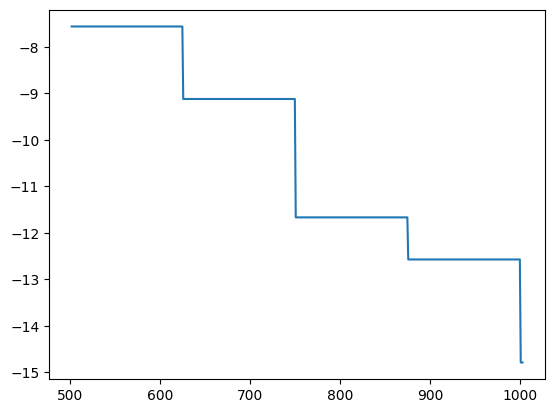

In [60]:
plt.plot(ep_rew['value'])

In [2]:
def eval_agent(agent, env, n_eval_episodes):
    total_rewards = []
    device = 'cpu'
    policy = agent.policy.to(device)  # Move observation to the same device as the model
    observation_space = env.observation_space
    print('observation space:', observation_space)
    
    for episode in range(n_eval_episodes):
        observation, info = env.reset()
        
        episode_reward = 0
        done = False

        while not done: 
            
            action = policy.predict(observation, deterministic=True)
            #print(action)
            observation, reward, terminated, truncated, info = env.step(action[0])
           
            observation =observation.reshape(2)
            if not observation_space.contains(observation):
                print("Observation is not valid:", observation)
            episode_reward += reward
            if terminated:
                done = True
            if truncated:
                done = True                   

        total_rewards.append(episode_reward)

    total_rewards = np.array(total_rewards)
    
    agent.policy.to('cuda')
    return np.mean(total_rewards), np.std(total_rewards), total_rewards

In [3]:
#agent_dir = 'RLmodels/MountainCarContinuous-v0/PPO_tuned_OG/PPO_tuned_OG3.zip'
#agent = PPO.load(agent_dir)

        #make env
env = gym.make("MountainCarContinuous-v0",
                    render_mode ='rgb_array')

In [135]:
rweard, std, alle = eval_agent(agent, env,1000)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


KeyboardInterrupt: 

In [ ]:
rweard

In [ ]:
std

In [ ]:
agents_dir = 'RLmodels/MountainCarContinuous-v0/PPO_tuned_OG'
plt.savefig('agent_performance_plot.png', bbox_inches='tight'
agent_names=[]
rewards = []
std_values = []
all_values = []

for agent_name in os.listdir(agents_dir):
    print(agent_name)
    agent = PPO.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 100)
    print(reward, std)
    rewards.append(reward)
    std_values.append(std)
    all_values.append(all_values_single)
    

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


NameError: name 'all_agents_data' is not defined

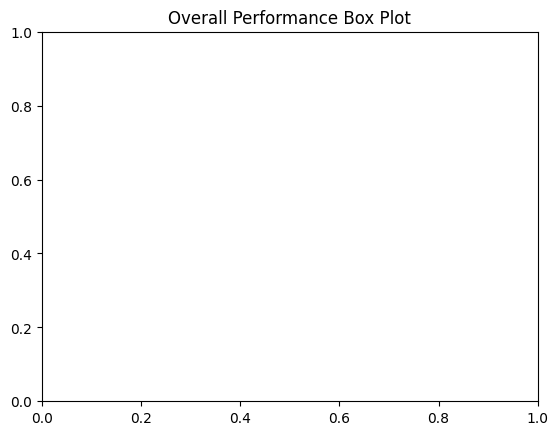

In [139]:
agents_data = []

for agent_name in os.listdir(agents_dir):
    agent = PPO.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 100)
    
    agents_data.append({'name': agent_name, 'reward': reward, 'std': std, 'rewards': all_values_single})

# Create a figure and axis for the overall box plot
fig1, ax1 = plt.subplots()
ax1.set_title('Overall Performance Box Plot')

# Extract rewards data for all agents together
all_rewards_data = [data['rewards'] for data in agents_data]

# Create a box plot for all agents
ax1.boxplot(all_rewards_data)
ax1.set_xticklabels([data['name'] for data in agents_data], rotation=45, ha="right")

plt.show()

# Create individual box plots for each agent
for agent_data in agents_data:
    fig, ax = plt.subplots()
    ax.set_title(f'Performance Box Plot - {agent_data["name"]}')
    ax.boxplot(agent_data['rewards'])
    plt.show()

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


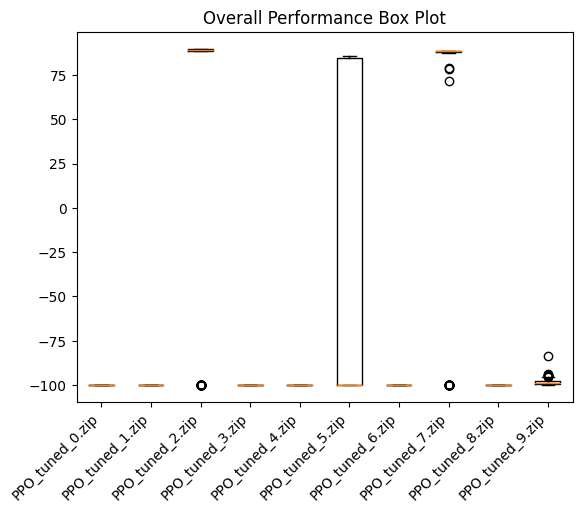

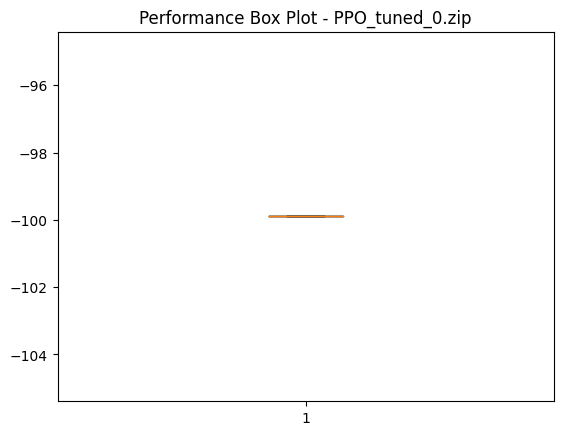

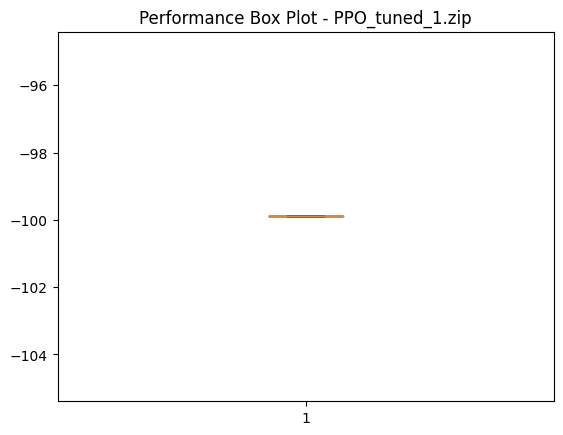

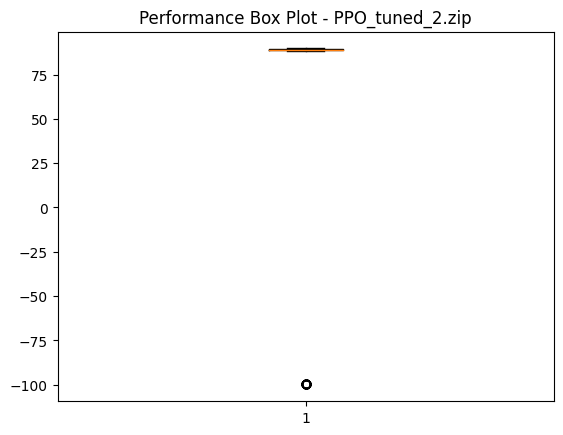

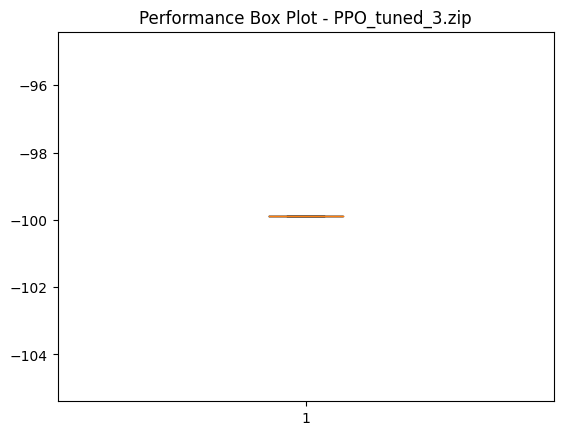

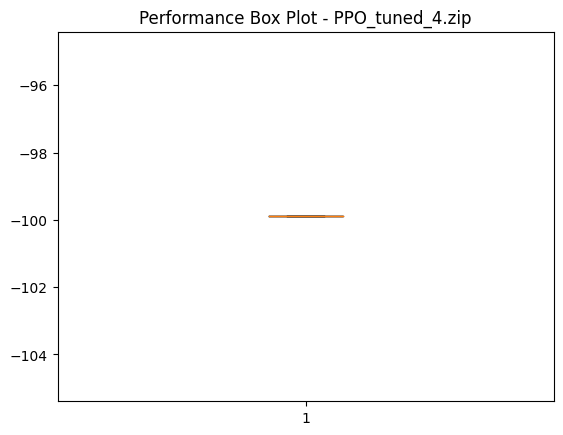

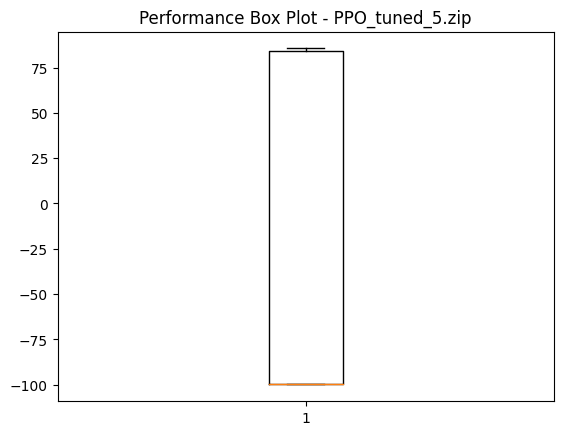

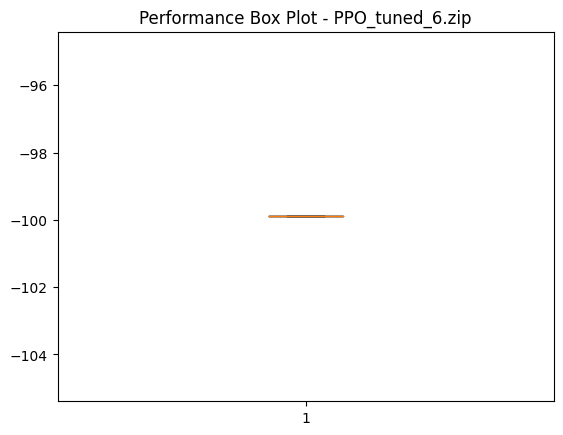

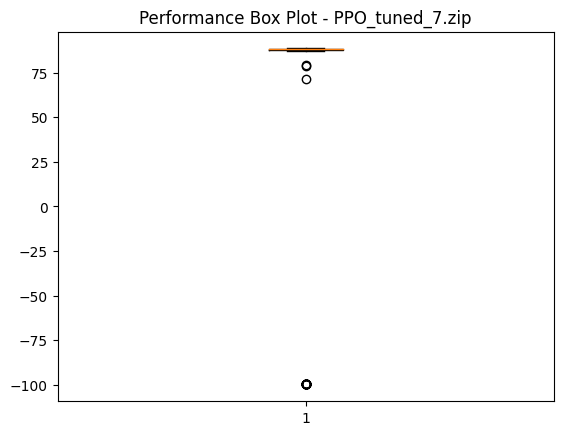

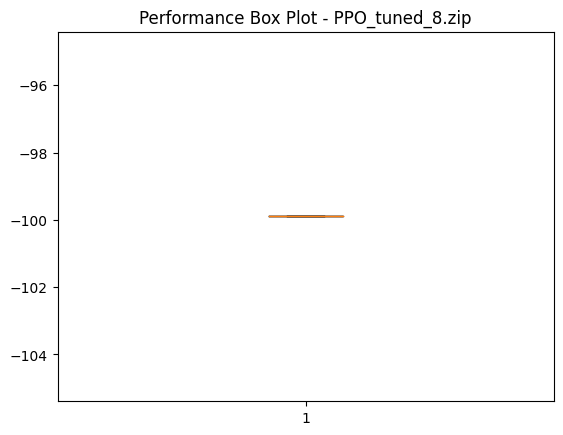

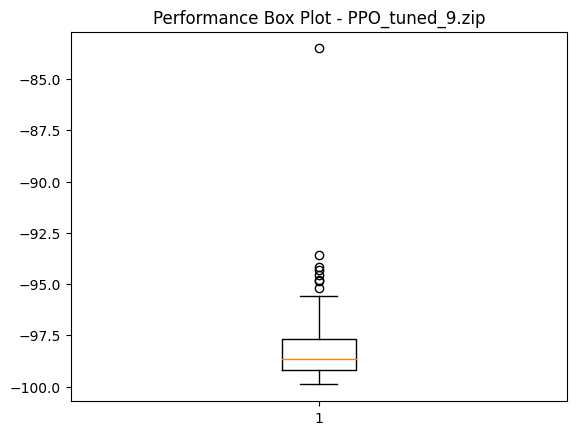

In [13]:
agents_data = []
agents_dir = 'RLmodels/MountainCarContinuous-v0/PPO_tuned_OG'
for agent_name in os.listdir(agents_dir):
    agent = PPO.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 200)
    
    agents_data.append({'name': agent_name, 'reward': reward, 'std': std, 'rewards': all_values_single})


# Create a figure and axis for the overall box plot
fig1, ax1 = plt.subplots()
ax1.set_title('Overall Performance Box Plot')

# Extract rewards data for all agents together
all_rewards_data = [data['rewards'] for data in agents_data]

# Create a box plot for all agents
ax1.boxplot(all_rewards_data)
ax1.set_xticklabels([data['name'] for data in agents_data], rotation=45, ha="right")

plt.show()

# Create individual box plots for each agent
for agent_data in agents_data:
    fig, ax = plt.subplots()
    ax.set_title(f'Performance Box Plot - {agent_data["name"]}')
    ax.boxplot(agent_data['rewards'])
    plt.show()

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


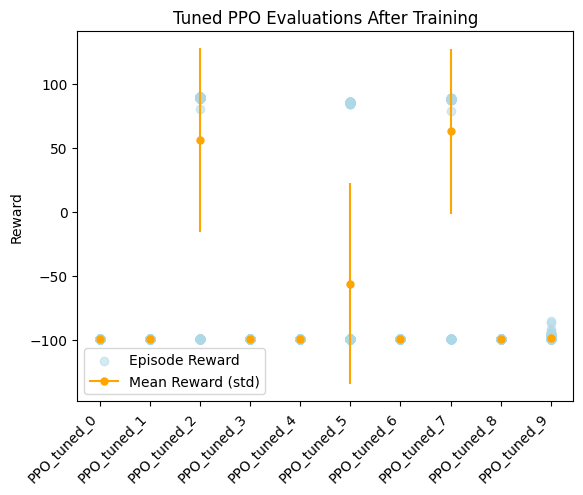

In [5]:
agents_data = []
agents_dir = 'RLmodels/MountainCarContinuous-v0/PPO_tuned_OG'
for agent_name in os.listdir(agents_dir):
    agent = PPO.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 200)
    
    agents_data.append({'name': agent_name, 'reward': reward, 'std': std, 'rewards': all_values_single})
# Create a figure and axis
fig, ax = plt.subplots()
ax.set_title('Tuned PPO Evaluations After Training')

for agent_data in agents_data:
    rewards = agent_data['rewards']
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Plot individual data points
    ax.scatter([agent_data['name']] * len(rewards), rewards, color='lightblue', alpha=0.5)
    
    # Plot the mean reward as a red line
    ax.plot([agent_data['name']], [mean_reward], marker='o', markersize=5, color='orange')
    
    # Plot error bars for the standard deviation
    ax.errorbar([agent_data['name']], [mean_reward], yerr=std_reward, color='orange')

# Set x-axis ticks and labels
ax.set_xticks(range(len(agents_data)))
ax.set_xticklabels([data['name'][:-4] for data in agents_data], rotation=45, ha="right")
ax.set_ylabel('Reward')
# Add a legend outside the loop
ax.legend(['Episode Reward','Mean Reward (std)'], loc='lower left')
plt.savefig('PPOEvaluationsRewardsof200Episodes.jpeg', bbox_inches='tight',dpi=300)
plt.show()

In [6]:
agents_dir = 'RLmodels/MountainCarContinuous-v0/SAC_tuned_OG'
agent_names=[]
rewards = []
std_values = []
all_values = []
agents_data =[]
for agent_name in os.listdir(agents_dir):
    agent = SAC.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 200)
    
    agents_data.append({'name': agent_name, 'reward': reward, 'std': std, 'rewards': all_values_single})

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


<Figure size 640x480 with 0 Axes>

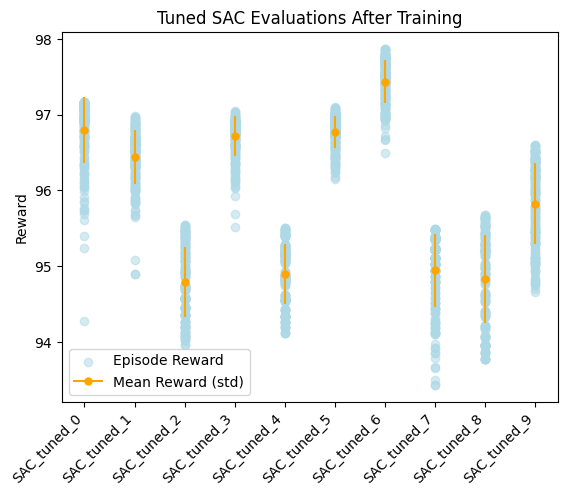

In [7]:
# Create a figure and axis
plt.clf()
fig, ax = plt.subplots()
ax.set_title('Tuned SAC Evaluations After Training')

for agent_data in agents_data:
    rewards = agent_data['rewards']
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Plot individual data points
    ax.scatter([agent_data['name']] * len(rewards), rewards, color='lightblue', alpha=0.5)
    
    # Plot the mean reward as a red line
    ax.plot([agent_data['name']], [mean_reward], marker='o', markersize=5, color='orange')
    
    # Plot error bars for the standard deviation
    ax.errorbar([agent_data['name']], [mean_reward], yerr=std_reward, color='orange')

# Set x-axis ticks and labels
#ax.set_xticks(range(len(agents_data)))
#ax.set_xticklabels([data['name'][:-4] for i,data in, agents_data], rotation=45, ha="right")
# Create a list of modified labels with consecutive numbers
modified_labels = [f"{data['name'][:-7]}{i}" for i, data in enumerate(agents_data)]

# Set x-axis ticks and labels with modified labels
ax.set_xticks(range(len(agents_data)))
ax.set_xticklabels(modified_labels, rotation=45, ha="right")

ax.set_ylabel('Reward')

# Add a legend outside the loop
ax.legend(['Episode Reward','Mean Reward (std)'], loc='lower left')
plt.savefig('SACEvaluationsRewardsof200Episodes.jpeg', bbox_inches='tight',dpi=300)
plt.show()

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Function to process and plot data for a single agent directory
def plot_agent_performance(agent_dir, agent_name, color):
    # Get a list of all CSV files in the directory
    csv_files = [file for file in os.listdir(agent_dir) if file.endswith(".csv")]

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Loop through each CSV file (assuming one file per epoch per agent)
    epoch = 0
    for epoch_csv in csv_files:
        # Load the CSV data for the current agent and epoch
        epoch_data = pd.read_csv(os.path.join(agent_dir, epoch_csv))

        # Calculate the mean and standard deviation of rewards for this epoch
        mean_reward = epoch_data.mean()
        std_reward = epoch_data.std()

        # Plot the mean rewards for this epoch
        ax.plot(epoch, mean_reward , marker='o', markersize=3,color = color, label=agent_name)
        ax.vlines(x=epoch, ymin=mean_reward - std_reward, ymax=mean_reward + std_reward, color=color)

        epoch+=1
        
        
    # Customize the plot as needed
    ax.set_title('Agent Performance Over Consecutive Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Reward')
    ax.legend()

    # Show the plot
    plt.show()



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_multiple_agents_performance(agent_dirs, agent_names, colors):
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    for agent_dir, agent_name, color in zip(agent_dirs, agent_names, colors):
        # Get a list of all CSV files in the directory
        csv_files = [file for file in os.listdir(agent_dir) if file.endswith(".csv")]
        
        # Initialize lists to store all rewards and corresponding epochs
        all_rewards = []
        all_epochs = []
        print(agent_name)
        # Loop through each CSV file (assuming one file per epoch per agent)
        epoch = 0
        for epoch_csv in csv_files:
            # Load the CSV data for the current agent and epoch
            epoch_data = pd.read_csv(os.path.join(agent_dir, epoch_csv), header = None)
            
            # Calculate the mean and standard deviation of rewards for this epoch
            mean_reward = epoch_data.mean()
            std_reward = epoch_data.std()
            print(agent_name, epoch)
            print('R',mean_reward)
            print('STD', std_reward)
            # Store the mean reward and epoch
            all_rewards.append(mean_reward)
            all_epochs.append(epoch)
            
            
            # Plot the mean rewards for this epoch as a dot
            ax.plot(epoch, mean_reward, marker='o', markersize=3, color=color, label=agent_name)

            # Plot whiskers (standard deviation)
            ax.vlines(x=epoch, ymin=mean_reward - std_reward, ymax=mean_reward + std_reward,alpha =0.5, color=color)

            epoch += 1

        # Connect the mean reward dots with a line for this agent
        ax.plot(all_epochs, all_rewards, linestyle='-', color=color)

    # Customize the plot as needed
    ax.set_title('Agent Performance Over Consecutive Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Reward')

    # Create custom legend handles (lines) to display agent names
    custom_legend_handles = [plt.Line2D([0], [0], color=color, linestyle='-', marker='o', markersize=3, label=agent_name) for agent_name, color in zip(agent_names, colors)]

    # Add the custom legend
    ax.legend(handles=custom_legend_handles)
    plt.savefig(agent_names[0]+'and_others_Rewards.jpeg', bbox_inches='tight',dpi=300)
    # Show the plot
    plt.show()

In [ ]:
plot_agent_performance('RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test1_PPO','VAE_l1_test1_PPO','orange')

VAE_l1_test2_PPO
VAE_l1_test2_PPO 0
R 0   -5.29739
dtype: float64
STD 0    0.013715
dtype: float64
VAE_l1_test2_PPO 1
R 0   -0.28775
dtype: float64
STD 0    0.14546
dtype: float64
VAE_l1_test2_PPO 2
R 0   -0.58433
dtype: float64
STD 0    0.009532
dtype: float64
VAE_l1_test2_PPO 3
R 0   -90.46011
dtype: float64
STD 0    0.550082
dtype: float64
VAE_l1_test2_PPO 4
R 0   -86.00916
dtype: float64
STD 0    0.726878
dtype: float64
VAE_l1_test2_PPO 5
R 0    82.692931
dtype: float64
STD 0    3.598514
dtype: float64
VAE_l1_test3_PPO
VAE_l1_test3_PPO 0
R 0   -2.14649
dtype: float64
STD 0    0.016641
dtype: float64
VAE_l1_test3_PPO 1
R 0   -5.12899
dtype: float64
STD 0    0.049887
dtype: float64
VAE_l1_test3_PPO 2
R 0   -0.70563
dtype: float64
STD 0    0.303972
dtype: float64
VAE_l1_test3_PPO 3
R 0   -1.86631
dtype: float64
STD 0    0.038879
dtype: float64
VAE_l1_test3_PPO 4
R 0    77.7696
dtype: float64
STD 0    3.452691
dtype: float64
VAE_l1_test3_PPO 5
R 0    88.00641
dtype: float64
STD 0    1.

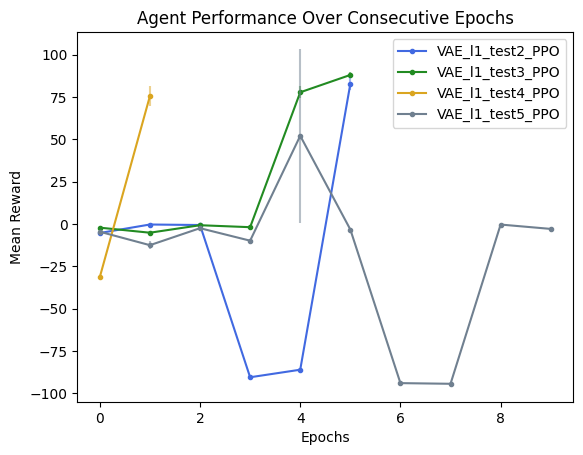

In [17]:

agent_dirs = [
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test2_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test3_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test4_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test5_PPO',

]
agent_names = ["VAE_l1_test2_PPO", "VAE_l1_test3_PPO", "VAE_l1_test4_PPO", "VAE_l1_test5_PPO"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "ForestGreen", "Goldenrod", "SlateGray", "Crimson"]  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

VAE_l1_test2_PPO
VAE_l1_test2_PPO 0
R 0   -5.29739
dtype: float64
STD 0    0.013715
dtype: float64
VAE_l1_test2_PPO 1
R 0   -0.28775
dtype: float64
STD 0    0.14546
dtype: float64
VAE_l1_test2_PPO 2
R 0   -0.58433
dtype: float64
STD 0    0.009532
dtype: float64
VAE_l1_test2_PPO 3
R 0   -90.46011
dtype: float64
STD 0    0.550082
dtype: float64
VAE_l1_test2_PPO 4
R 0   -86.00916
dtype: float64
STD 0    0.726878
dtype: float64
VAE_l1_test2_PPO 5
R 0    82.692931
dtype: float64
STD 0    3.598514
dtype: float64
VAE_l1_test3_PPO
VAE_l1_test3_PPO 0
R 0   -2.14649
dtype: float64
STD 0    0.016641
dtype: float64
VAE_l1_test3_PPO 1
R 0   -5.12899
dtype: float64
STD 0    0.049887
dtype: float64
VAE_l1_test3_PPO 2
R 0   -0.70563
dtype: float64
STD 0    0.303972
dtype: float64
VAE_l1_test3_PPO 3
R 0   -1.86631
dtype: float64
STD 0    0.038879
dtype: float64
VAE_l1_test3_PPO 4
R 0    77.7696
dtype: float64
STD 0    3.452691
dtype: float64
VAE_l1_test3_PPO 5
R 0    88.00641
dtype: float64
STD 0    1.

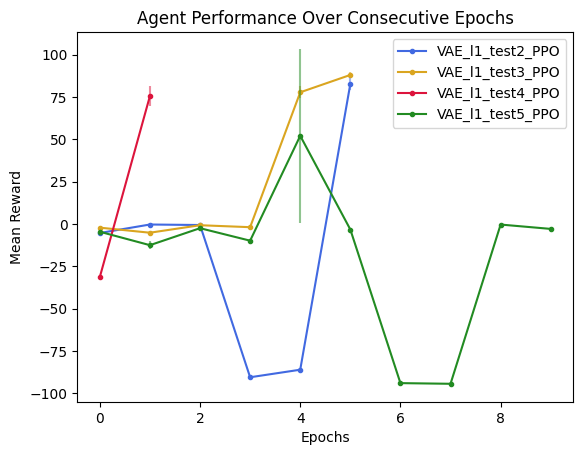

In [18]:
agent_dirs = [
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test2_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test3_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test4_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l1_test5_PPO',

]
agent_names = ["VAE_l1_test2_PPO", "VAE_l1_test3_PPO", "VAE_l1_test4_PPO", "VAE_l1_test5_PPO"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "Goldenrod", "Crimson","ForestGreen", "SlateGray"]  # Specify colors for each agent
  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

VAE_l2_test1_PPO
VAE_l2_test1_PPO 0
R 0   -13.66438
dtype: float64
STD 0    1.783025
dtype: float64
VAE_l2_test1_PPO 1
R 0   -20.08817
dtype: float64
STD 0    21.276391
dtype: float64
VAE_l2_test1_PPO 2
R 0   -53.35935
dtype: float64
STD 0    7.355585
dtype: float64
VAE_l2_test1_PPO 3
R 0   -79.96863
dtype: float64
STD 0    2.724275
dtype: float64
VAE_l2_test1_PPO 4
R 0   -77.92948
dtype: float64
STD 0    4.483975
dtype: float64
VAE_l2_test1_PPO 5
R 0   -44.516881
dtype: float64
STD 0    5.666081
dtype: float64
VAE_l2_test1_PPO 6
R 0   -72.855334
dtype: float64
STD 0    1.713764
dtype: float64
VAE_l2_test1_PPO 7
R 0   -86.378634
dtype: float64
STD 0    2.124868
dtype: float64
VAE_l2_test1_PPO 8
R 0    50.48788
dtype: float64
STD 0    10.303752
dtype: float64
VAE_l2_test1_PPO 9
R 0   -95.923045
dtype: float64
STD 0    0.596089
dtype: float64
VAE_l2_test2_PPO
VAE_l2_test2_PPO 0
R 0   -7.2001
dtype: float64
STD 0    0.215613
dtype: float64
VAE_l2_test2_PPO 1
R 0   -20.55241
dtype: float64

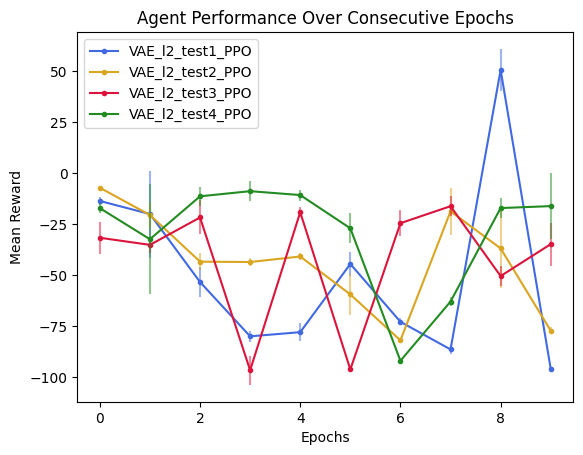

In [11]:
agent_dirs = [
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l2_test1_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l2_test2_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l2_test3_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l2_test4_PPO',
]
agent_names = ["VAE_l2_test1_PPO","VAE_l2_test2_PPO", "VAE_l2_test3_PPO", "VAE_l2_test4_PPO"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "Goldenrod", "Crimson","ForestGreen", "SlateGray"]  # Specify colors for each agent
  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

VAE_l3_test1_PPO
VAE_l3_test1_PPO 0
R 0   -8.66134
dtype: float64
STD 0    0.089797
dtype: float64
VAE_l3_test1_PPO 1
R 0   -4.49052
dtype: float64
STD 0    2.251535
dtype: float64
VAE_l3_test1_PPO 2
R 0   -30.70551
dtype: float64
STD 0    1.399984
dtype: float64
VAE_l3_test1_PPO 3
R 0   -12.69549
dtype: float64
STD 0    0.688095
dtype: float64
VAE_l3_test1_PPO 4
R 0   -22.671
dtype: float64
STD 0    1.016351
dtype: float64
VAE_l3_test1_PPO 5
R 0   -41.906062
dtype: float64
STD 0    0.822959
dtype: float64
VAE_l3_test1_PPO 6
R 0   -80.878684
dtype: float64
STD 0    1.940081
dtype: float64
VAE_l3_test1_PPO 7
R 0   -76.987927
dtype: float64
STD 0    3.193213
dtype: float64
VAE_l3_test1_PPO 8
R 0   -22.92802
dtype: float64
STD 0    61.933915
dtype: float64
VAE_l3_test1_PPO 9
R 0    28.474374
dtype: float64
STD 0    47.292448
dtype: float64
VAE_l3_test2_PPO
VAE_l3_test2_PPO 0
R 0   -5.2308
dtype: float64
STD 0    0.053549
dtype: float64
VAE_l3_test2_PPO 1
R 0   -8.13167
dtype: float64
STD 

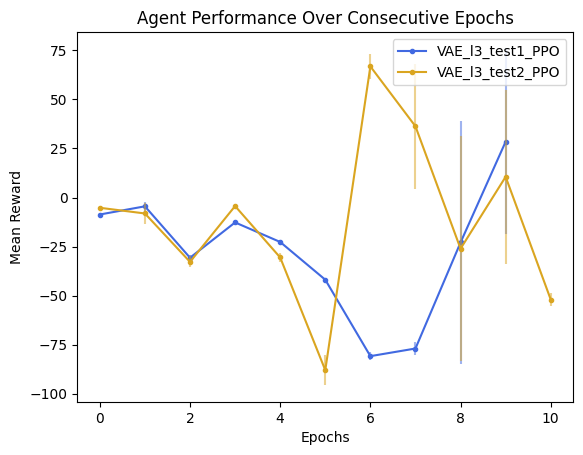

In [19]:
agent_dirs = [
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l3_test1_PPO',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/PPO/VAE_l3_test2_PPO',
]
agent_names = ["VAE_l3_test1_PPO","VAE_l3_test2_PPO"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "Goldenrod", "Crimson","ForestGreen", "SlateGray"]  # Specify colors for each agent
  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

VAE_l1_test2_A2C
VAE_l1_test2_A2C 0
R 0   -99.9
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test2_A2C 1
R 0   -99.9
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test2_A2C 2
R 0   -99.9
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test2_A2C 3
R 0   -99.02757
dtype: float64
STD 0    0.757926
dtype: float64
VAE_l1_test2_A2C 4
R 0   -99.9
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test2_A2C 5
R 0   -99.9
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test2_A2C 6
R 0   -92.994443
dtype: float64
STD 0    28.32568
dtype: float64
VAE_l1_test2_A2C 7
R 0   -99.899714
dtype: float64
STD 0    0.00239
dtype: float64
VAE_l1_test2_A2C 8
R 0   -91.723447
dtype: float64
STD 0    31.3499
dtype: float64
VAE_l1_test2_A2C 9
R 0    60.121296
dtype: float64
STD 0    7.119619
dtype: float64
VAE_l1_test3_A2C
VAE_l1_test3_A2C 0
R 0   -99.9
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test3_A2C 1
R 0   -99.9
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test3_A2C 2
R 0   -99.9


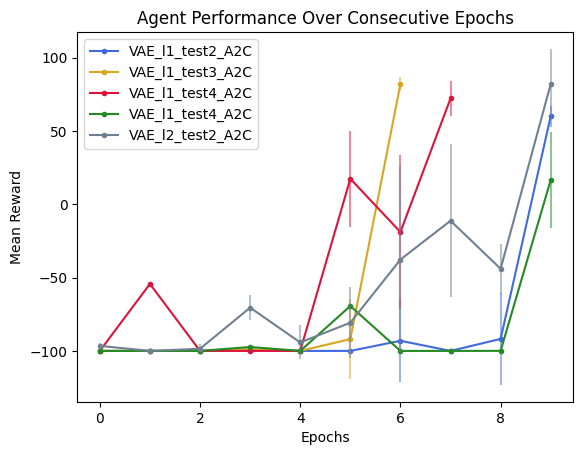

In [13]:
agent_dirs = [
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/A2C/VAE_l1_test2_A2C',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/A2C/VAE_l1_test3_A2C',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/A2C/VAE_l1_test4_A2C',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/A2C/VAE_l1_test5_A2C',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/A2C/VAE_l2_test2_A2C',

]
agent_names = ["VAE_l1_test2_A2C", "VAE_l1_test3_A2C", "VAE_l1_test4_A2C", "VAE_l1_test4_A2C", "VAE_l2_test2_A2C"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "Goldenrod", "Crimson","ForestGreen", "SlateGray"]  # Specify colors for each agent
  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

VAE_l1_test1_SAC
VAE_l1_test1_SAC 0
R 0   -0.31119
dtype: float64
STD 0    0.0156
dtype: float64
VAE_l1_test1_SAC 1
R 0   -7.2297
dtype: float64
STD 0    0.166895
dtype: float64
VAE_l1_test1_SAC 2
R 0   -21.75161
dtype: float64
STD 0    0.661287
dtype: float64
VAE_l1_test1_SAC 3
R 0   -88.38248
dtype: float64
STD 0    5.465546
dtype: float64
VAE_l1_test1_SAC 4
R 0   -23.3824
dtype: float64
STD 0    2.548478
dtype: float64
VAE_l1_test1_SAC 5
R 0    48.109581
dtype: float64
STD 0    48.375897
dtype: float64
VAE_l1_test1_SAC 6
R 0   -36.943366
dtype: float64
STD 0    1.062211
dtype: float64
VAE_l1_test1_SAC 7
R 0   -6.175462
dtype: float64
STD 0    25.446739
dtype: float64
VAE_l1_test1_SAC 8
R 0   -4.296098
dtype: float64
STD 0    4.959355
dtype: float64
VAE_l1_test1_SAC 9
R 0   -36.491036
dtype: float64
STD 0    20.351568
dtype: float64
VAE_l1_test2_SAC
VAE_l1_test2_SAC 0
R 0   -92.842
dtype: float64
STD 0    0.0
dtype: float64
VAE_l1_test2_SAC 1
R 0   -76.15158
dtype: float64
STD 0    4

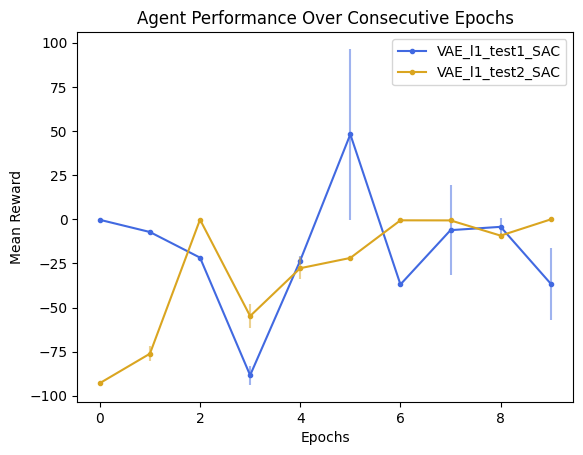

In [14]:
agent_dirs = [
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/SAC/VAE_l1_test1_SAC',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/SAC/VAE_l1_test2_SAC',

]
agent_names = ["VAE_l1_test1_SAC", "VAE_l1_test2_SAC"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "Goldenrod", "Crimson","ForestGreen", "SlateGray"]  # Specify colors for each agent
  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

VAE_l2_test1_SAC
VAE_l2_test1_SAC 0
R 0   -9.9434
dtype: float64
STD 0    0.689525
dtype: float64
VAE_l2_test1_SAC 1
R 0   -7.40544
dtype: float64
STD 0    0.4777
dtype: float64
VAE_l2_test1_SAC 2
R 0   -47.67444
dtype: float64
STD 0    0.728648
dtype: float64
VAE_l2_test1_SAC 3
R 0   -16.21817
dtype: float64
STD 0    0.56455
dtype: float64
VAE_l2_test1_SAC 4
R 0   -20.11961
dtype: float64
STD 0    10.238698
dtype: float64
VAE_l2_test1_SAC 5
R 0   -62.693619
dtype: float64
STD 0    2.044771
dtype: float64
VAE_l2_test1_SAC 6
R 0   -12.419219
dtype: float64
STD 0    15.32392
dtype: float64
VAE_l2_test1_SAC 7
R 0   -48.080129
dtype: float64
STD 0    8.238926
dtype: float64
VAE_l2_test1_SAC 8
R 0   -78.904833
dtype: float64
STD 0    1.129156
dtype: float64
VAE_l2_test1_SAC 9
R 0   -16.133077
dtype: float64
STD 0    0.876664
dtype: float64
VAE_l2_test2_SAC
VAE_l2_test2_SAC 0
R 0   -12.29214
dtype: float64
STD 0    0.575049
dtype: float64
VAE_l2_test2_SAC 1
R 0   -3.07297
dtype: float64
STD 

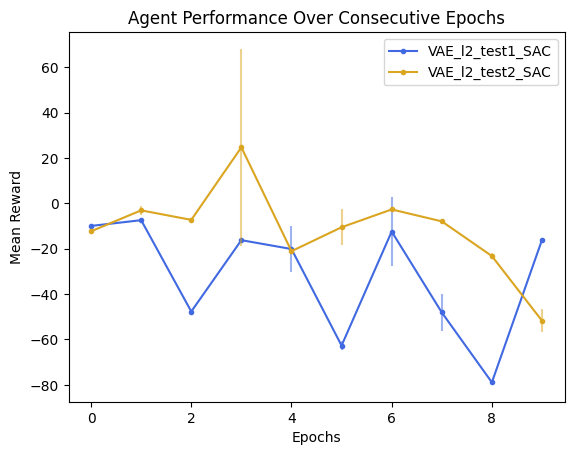

In [15]:
agent_dirs = [
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/SAC/VAE_l2_test1_SAC',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/SAC/VAE_l2_test2_SAC',

]
agent_names = [
               "VAE_l2_test1_SAC", "VAE_l2_test2_SAC"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "Goldenrod", "Crimson","ForestGreen", "SlateGray"]  # Specify colors for each agent
  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

VAE_l3_test1_SAC
VAE_l3_test1_SAC 0
R 0   -28.21525
dtype: float64
STD 0    0.014507
dtype: float64
VAE_l3_test1_SAC 1
R 0   -35.79466
dtype: float64
STD 0    9.107547
dtype: float64
VAE_l3_test1_SAC 2
R 0    3.83882
dtype: float64
STD 0    38.457379
dtype: float64
VAE_l3_test1_SAC 3
R 0   -23.46248
dtype: float64
STD 0    9.127485
dtype: float64
VAE_l3_test1_SAC 4
R 0   -50.6076
dtype: float64
STD 0    1.115361
dtype: float64
VAE_l3_test1_SAC 5
R 0   -38.735563
dtype: float64
STD 0    15.472482
dtype: float64
VAE_l3_test1_SAC 6
R 0   -0.511109
dtype: float64
STD 0    55.955928
dtype: float64
VAE_l3_test1_SAC 7
R 0   -76.548248
dtype: float64
STD 0    4.920876
dtype: float64
VAE_l3_test1_SAC 8
R 0   -60.145618
dtype: float64
STD 0    1.827276
dtype: float64
VAE_l3_test1_SAC 9
R 0   -86.472
dtype: float64
STD 0    1.665002
dtype: float64
VAE_l3_test2_SAC
VAE_l3_test2_SAC 0
R 0   -8.64016
dtype: float64
STD 0    0.063128
dtype: float64
VAE_l3_test2_SAC 1
R 0   -24.72959
dtype: float64
ST

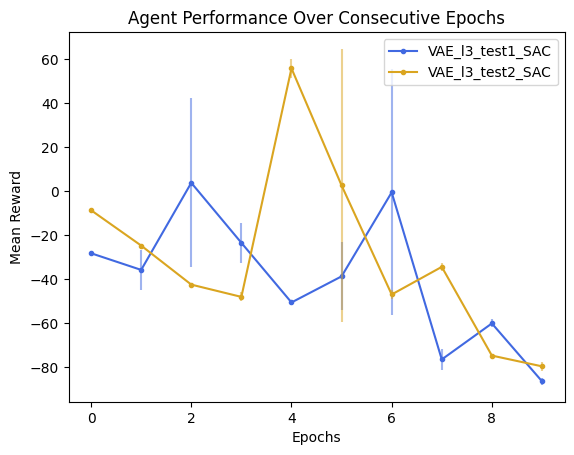

In [16]:
agent_dirs = [

    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/SAC/VAE_l3_test1_SAC',
    'RLmodels/MountainCarContinuous-v0/Double_loop/rewards/SAC/VAE_l3_test2_SAC',

]
agent_names = [
               "VAE_l3_test1_SAC","VAE_l3_test2_SAC"]  # Add agent names in the same order as directories
colors = ["RoyalBlue", "Goldenrod", "Crimson","ForestGreen", "SlateGray"]  # Specify colors for each agent
  # Specify colors for each agent

plot_multiple_agents_performance(agent_dirs, agent_names, colors)

##### 